## Data understanding
Importing libraries, reading the dataset and displaying some basic information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

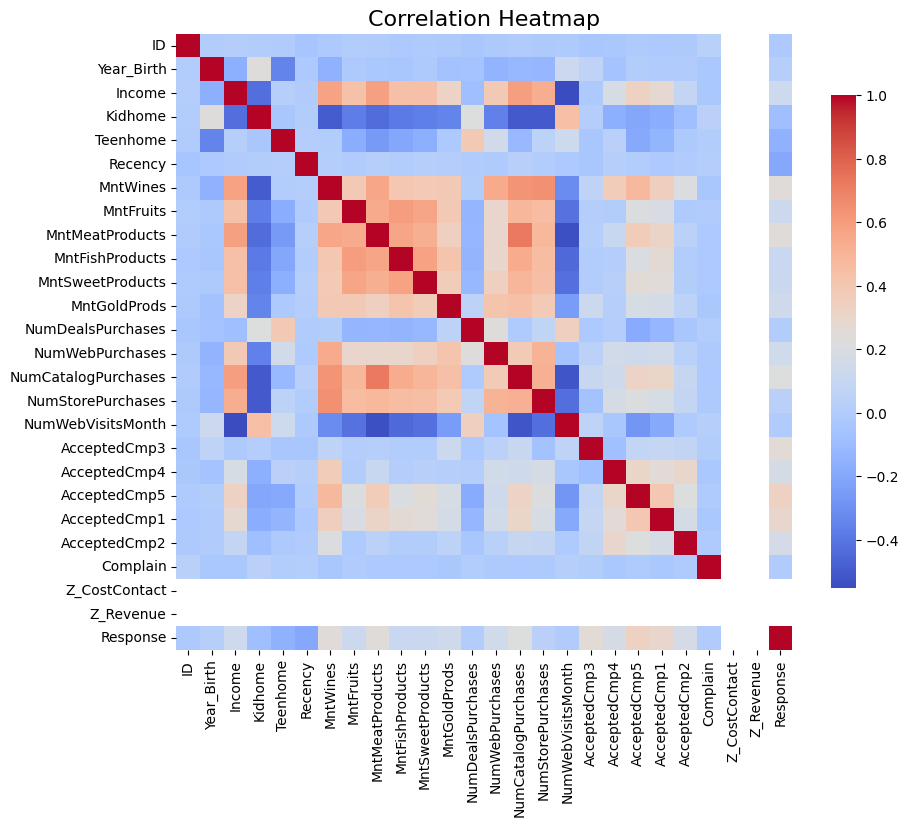

In [566]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import numpy as np

df = pd.read_csv("marketing_campaign.csv",sep='\t',header=(0))
print(df.info())
print(df.nunique())
print(df[['Education']].value_counts())
print(df[['Marital_Status']].value_counts())

matrix = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

## Data preperation and feature engineering
Dropping NaN rows, converting all data to numerical data through feature engineering and/or creating dummy columns and creating new data with the existing data

In [567]:
df = df.dropna() # income contains nulls

#Feature engineering
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
df['Days_Since_Joining'] = (pd.to_datetime('today') - df['Dt_Customer']).dt.days
df['Year_Enrolled'] = df['Dt_Customer'].dt.year
df['Customer_Age'] = (pd.to_datetime('today').year - df['Year_Birth'])
df['Total_kids'] = df[['Kidhome', 'Teenhome']].sum(axis=1)

# Aggegrating similar columns
df['Spending'] = df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
df['Number_of_purchases'] = df[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)
df['Total_Campaigns_Accepted'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)
df = df.drop(['Dt_Customer', 'Z_Revenue', 'Z_CostContact', 'ID', 'Year_Birth'], axis=1)


print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Education                 2216 non-null   object 
 1   Marital_Status            2216 non-null   object 
 2   Income                    2216 non-null   float64
 3   Kidhome                   2216 non-null   int64  
 4   Teenhome                  2216 non-null   int64  
 5   Recency                   2216 non-null   int64  
 6   MntWines                  2216 non-null   int64  
 7   MntFruits                 2216 non-null   int64  
 8   MntMeatProducts           2216 non-null   int64  
 9   MntFishProducts           2216 non-null   int64  
 10  MntSweetProducts          2216 non-null   int64  
 11  MntGoldProds              2216 non-null   int64  
 12  NumDealsPurchases         2216 non-null   int64  
 13  NumWebPurchases           2216 non-null   int64  
 14  NumCatalogPur

## Cleaning messy data
Mapping values from the education and marital status columns to more basic categories. This reduces unnecessary complexity and allows the model to make better clusters.

In [568]:
print(df[['Education']].value_counts())
print(df[['Marital_Status']].value_counts())

df['Education'] = df['Education'].replace(
    {'Graduation': 'Graduation',
     'PhD': 'Postgraduate',
     'Master': 'Postgraduate',
     '2n Cycle': 'Postgraduate',
     'Basic': 'Other'})

print(df[['Education']].value_counts())

df = df[~df['Marital_Status'].isin(['Absurd', 'YOLO'])]

df['Marital_Status'] = df['Marital_Status'].replace(
    {'Married': 'Together',
     'Together': 'Together',
     'Single': 'Single',
     'Divorced': 'Single',
     'Widow': 'Single',
     'Alone': 'Single'}
)

print(df[['Marital_Status']].value_counts())

df = pd.get_dummies(df, columns=['Education', 'Marital_Status']).astype(int)
print(df.head(5))
print(df.info())

Education 
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64
Marital_Status
Married           857
Together          573
Single            471
Divorced          232
Widow              76
Alone               3
Absurd              2
YOLO                2
Name: count, dtype: int64
Education   
Graduation      1116
Postgraduate    1046
Other             54
Name: count, dtype: int64
Marital_Status
Together          1430
Single             782
Name: count, dtype: int64
   Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  MntMeatProducts  \
0   58138        0         0       58       635         88              546   
1   46344        1         1       38        11          1                6   
2   71613        0         0       26       426         49              127   
3   26646        1         0       26        11          4               20   
4   58293        1         0       94       173         43         

## Modelling: Finding and creating the optimal number of clusters

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'Days_Since_Joining', 'Year_Enrolled', 'Customer_Age', 'Total_kids',
       'Spending', 'Number_of_purchases', 'Total_Campaigns_Accepted'],
      dtype='object')


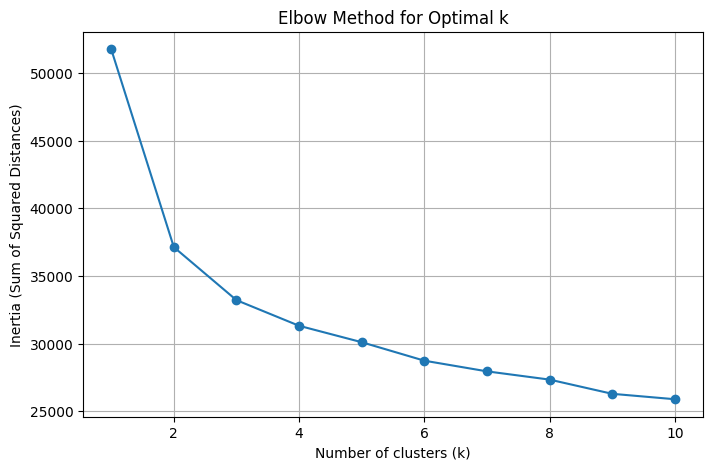

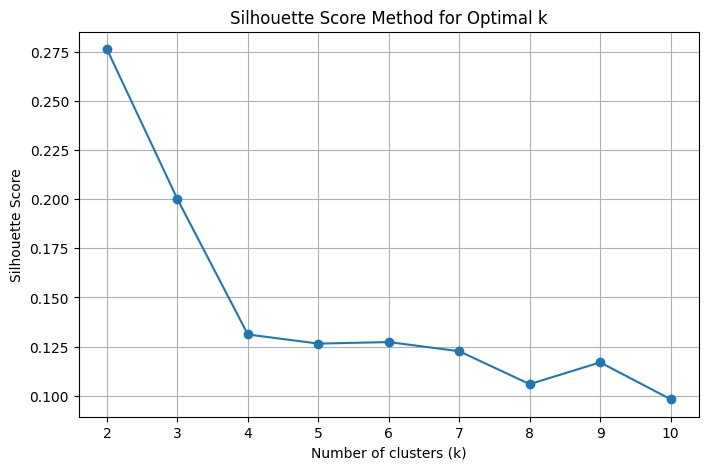

In [569]:
# List all non-dummy columns (columns with no less than 2 values)
x = df.drop(columns=df.columns[(df.nunique() < 3)])
print(x.columns)

non_dummy_columns = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'Days_Since_Joining', 'Year_Enrolled', 'Customer_Age', 'Total_kids',
       'Spending', 'Number_of_purchases', 'Total_Campaigns_Accepted']

scaler = StandardScaler()
scaled_df = df.copy()

# Only scaling the non-dummy columns while keeping the binary columns unchanged.
scaled_df[non_dummy_columns] = scaler.fit_transform(scaled_df[non_dummy_columns])

# Determining the optimal number of clusters with the Elbow method
k_values = range(1, 11)

inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    inertias.append(kmeans.inertia_)
    
# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Based on the elbow curve the optimal number of clusters is likely between 2 and 4.
# Determining the optimal number of clusters with the silhouette score. Since silhouette score determines the distinctness of groups, there have to be at least 2 clusters.

k_values = range(2, 11)

silhouette_scores = []

# Run KMeans and compute the silhouette score for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_df)
    score = silhouette_score(scaled_df, labels)
    silhouette_scores.append(score)

# Plot the Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method for Optimal k')
plt.grid(True)
plt.show()

# The silhouette score is the highest with 2 clusters, but based on the elbow line 3 is probably a better balance between distinction and representation.

## Improving the data using PCA (Principal component analysis)

PCA reduces the number of dimensions to the principal components, reducing the dimensions of the dataset while maintaining most of the information. 
This should in theory enable the Elbow method, Silhouette scoreing and K-means to perform better.

15


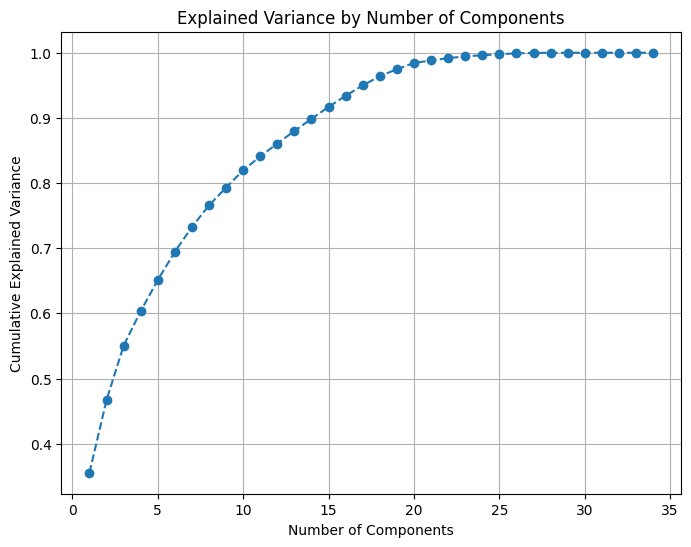

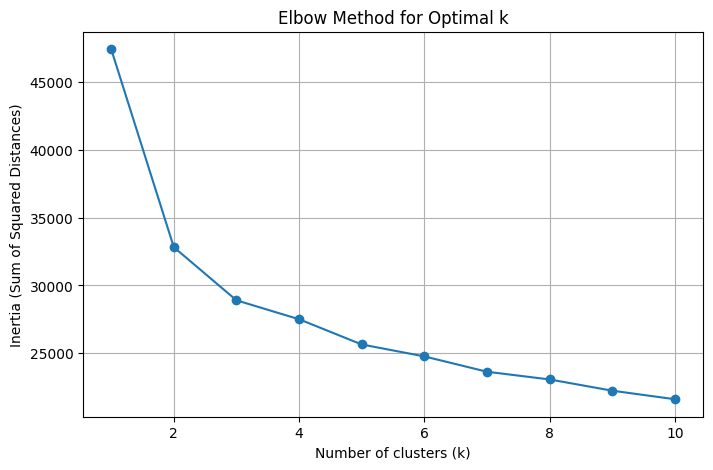

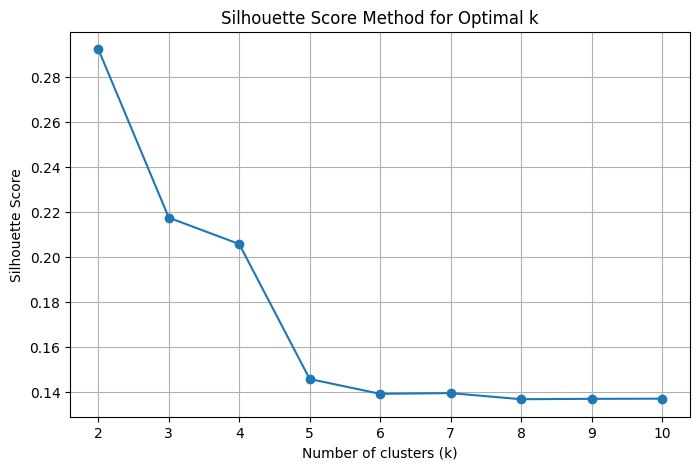

In [ ]:
# First initializing PCA and fitting it on the scaled dataset.
pca = PCA()
X_pca = pca.fit_transform(scaled_df)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Calculating the required amount of components to still explain 90% of the dataset. This ensures the reduced dimensions still cover most of the original information with reduced dimensions.
n_components_90 = np.argmax(explained_variance >= 0.90) + 1
print(n_components_90)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

# Initializing PCA again, now with the previously calculated optimal amount of components.
pca = PCA(n_components_90)
X_pca = pca.fit_transform(scaled_df)

#Determining the optimal number of clusters with the Elbow Method on the PCA-fitted dataset
k_values = range(1, 11)

inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)
    
# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

#Determining the optimal number of clusters with the Silhouette score on the PCA-fitted dataset
k_values = range(2, 11)

silhouette_scores = []

# Run KMeans and compute the silhouette score for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)

# Plot the Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method for Optimal k')
plt.grid(True)
plt.show()

# The conclusion remains the same, but the accuracy of the models have improved, as indicated by the lower inertia and higher silhouette score.

## Modelling: Fitting KMeans

When comparing the of the Inertia in the elbow method for the scaled dataset and the PCA dataset, you can see the inertia is smaller after applying PCA. The Silhouette score is also higher than when only scaled. This means applying PCA improved the distinctiveness of each group and the representativeness of its members. For this reason the KMeans model will be fitted on the dataset with PCA applied.

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
# Fitting the clusters on normalized and pca-applied data
clusters = kmeans.fit_predict(X_pca)

# Adding the clusters into the unnormalized, source dataset. 
# This way, you have the benefits of training your model on normalized and optimized data while also having the benefits of the easily interpretable source data.
df['Cluster'] = clusters
print(df['Cluster'].value_counts())

# Swapping in order of income because this makes visuals easier to interpret.
mapping = {1: 2, 0: 1, 2: 0}

# Applying the mapping to re-order clusters
df['Cluster'] = df['Cluster'].map(mapping)
cluster_profiles = df.groupby('Cluster').mean()

Cluster
2    1042
0     592
1     578
Name: count, dtype: int64


## General Cluster Characteristics
Discovering the general characterisctics of each cluster by calculating descriptive statistics for each cluster.

In [572]:
print(df.columns)

def cluster_profile(df):
    # Define the aggregations for other features (Income, Age, etc.)
    aggregations = {
        'Income': ['median', 'mean'],
        'Customer_Age': ['median', 'mean'],
        'Kidhome': 'mean',
        'Teenhome': 'mean',
        'Total_kids': 'median',
        'Spending': ['median', 'mean'],
        'Days_Since_Joining': ['median', 'mean'],
        'NumStorePurchases': ['mean', 'median'],
        'NumWebVisitsMonth': ['mean', 'median'],
        'NumDealsPurchases': ['mean', 'median'],
        'NumWebPurchases': ['mean', 'median'],
        'NumCatalogPurchases': ['mean', 'median'],
        'MntGoldProds': ['mean', 'median'],
        'MntWines': ['mean', 'median'],
        'MntFruits': ['mean', 'median'],
        'MntMeatProducts': ['mean', 'median'],
        'MntFishProducts': ['mean', 'median'],
        'MntSweetProducts': ['mean', 'median'],
        'MntGoldProds': ['mean', 'median'],
        'Complain': ['mean', 'median']
    }

    # Perform groupby and aggregate
    profile = df.groupby('Cluster').agg(aggregations)

    # Calculate total number of people in each cluster (for marital status)
    total_people = df.groupby('Cluster')[['Marital_Status_Single', 'Marital_Status_Together']].sum().sum(axis=1)

    # Calculate marital status percentages directly
    marital_status = df.groupby('Cluster')[['Marital_Status_Single', 'Marital_Status_Together']].sum().div(total_people, axis=0) * 100

    # Calculate total number of people in each cluster for education categories
    total_education = df.groupby('Cluster')[['Education_Graduation', 'Education_Postgraduate', 'Education_Other']].sum().sum(axis=1)

    # Calculate education percentages directly
    education_status = df.groupby('Cluster')[['Education_Graduation', 'Education_Postgraduate', 'Education_Other']].sum().div(total_education, axis=0) * 100

    # Combine the profile with the calculated percentages
    profile = pd.concat([profile, marital_status, education_status], axis=1)

    return profile

# Generate the cluster profile
cluster_summary = cluster_profile(df)

# Display the summary
print(cluster_summary)

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Days_Since_Joining',
       'Year_Enrolled', 'Customer_Age', 'Total_kids', 'Spending',
       'Number_of_purchases', 'Total_Campaigns_Accepted',
       'Education_Graduation', 'Education_Other', 'Education_Postgraduate',
       'Marital_Status_Single', 'Marital_Status_Together', 'Cluster'],
      dtype='object')
         (Income, median)  (Income, mean)  (Customer_Age, median)  \
Cluster                                                             
0                 34616.5    35224.286948                    51.0   
1                 58329.0    57914.694257                    59.0   
2              

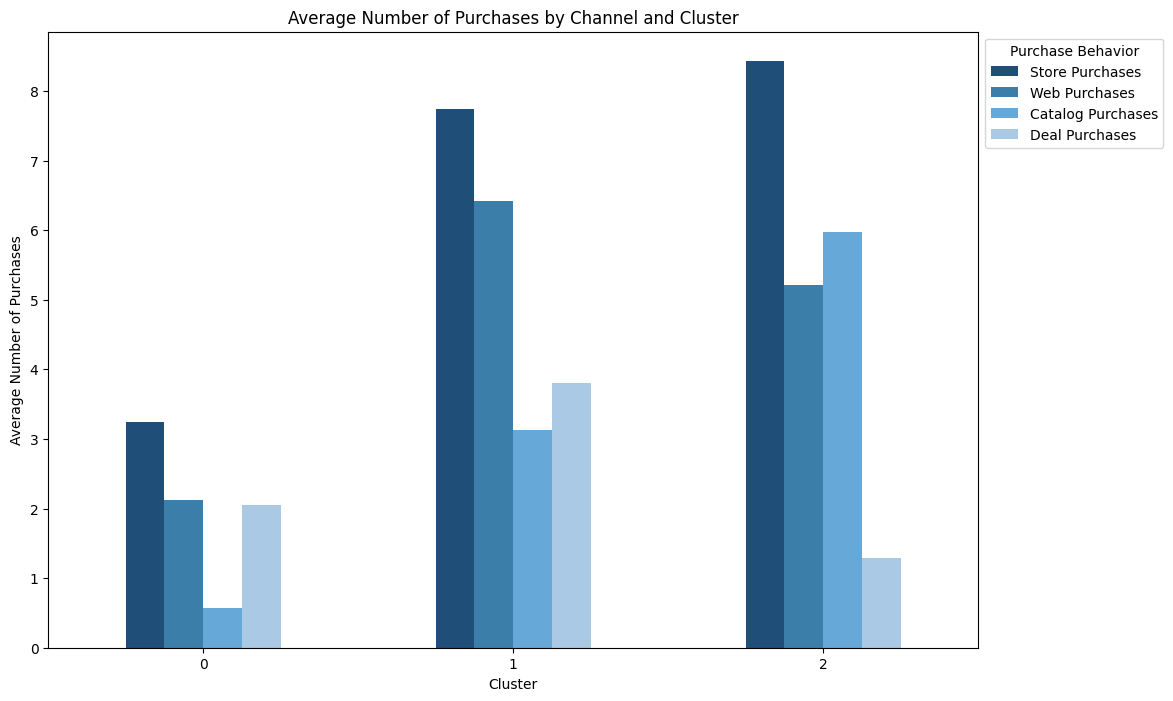

In [573]:
# Purchase channels columns
purchase_cols = ['NumStorePurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumDealsPurchases']

Channel_labels = {
    'NumStorePurchases': 'Store Purchases',
    'NumWebPurchases': 'Web Purchases',
    'NumCatalogPurchases': 'Catalog Purchases',
    'NumDealsPurchases': 'Deal Purchases',
}

# Average number of purchases by cluster
purchase_data = df.groupby('Cluster')[purchase_cols].mean()

# Map the columns to the readable labels for the legend
purchase_data = purchase_data.rename(columns=Channel_labels)

colors = ['#1F4E79', '#3C7EAA', '#66A9D8', '#A9C9E5', '#D1E3F1', '#A1B3B4']

# Grouped bar chart
purchase_data.plot(kind='bar', figsize=(12, 8), color=colors)
plt.title("Average Number of Purchases by Channel and Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Number of Purchases")
plt.legend(title="Purchase Behavior", loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)
plt.show()

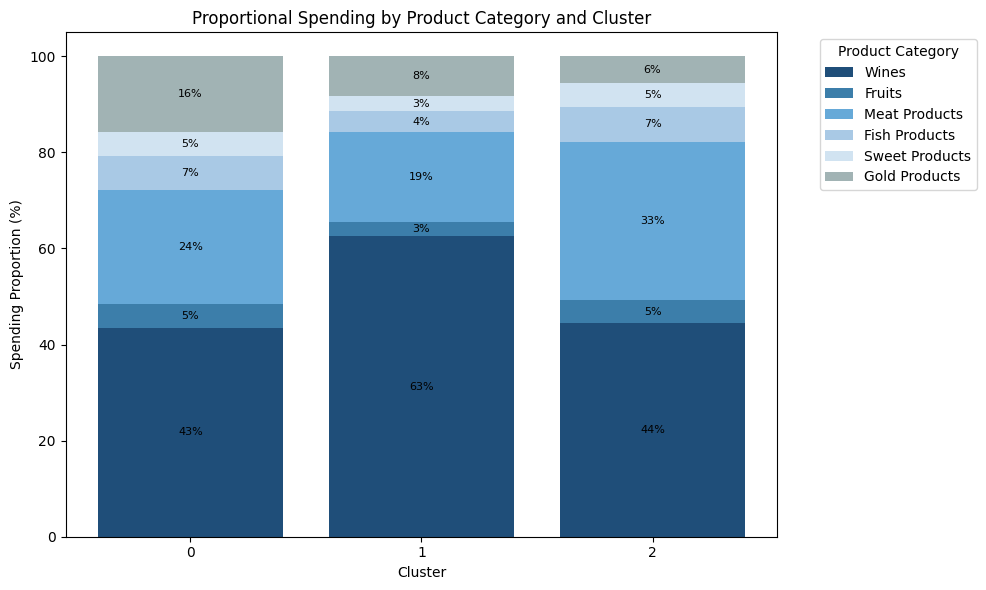

In [574]:
import matplotlib.pyplot as plt

# Spending columns
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

# Define a dictionary mapping the original column names to more readable product names
product_labels = {
    'MntWines': 'Wines',
    'MntFruits': 'Fruits',
    'MntMeatProducts': 'Meat Products',
    'MntFishProducts': 'Fish Products',
    'MntSweetProducts': 'Sweet Products',
    'MntGoldProds': 'Gold Products'
}

# Calculate proportional spending by category for each cluster
proportional_spending = df.groupby('Cluster')[spending_cols].sum()
proportional_spending = proportional_spending.div(proportional_spending.sum(axis=1), axis=0) * 100  # Convert to percentages

# color palette for all visuals
colors = ['#1F4E79', '#3C7EAA', '#66A9D8', '#A9C9E5', '#D1E3F1', '#A1B3B4']

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each product category as a stacked segment in the bar chart
bottoms = [0] * len(proportional_spending.index)
for idx, col in enumerate(spending_cols):
    ax.bar(proportional_spending.index, proportional_spending[col], bottom=bottoms, label=product_labels[col], color=colors[idx])

    # Add data labels
    for cluster_idx, value in enumerate(proportional_spending[col]):
        ax.text(cluster_idx, bottoms[cluster_idx] + value / 2, f"{value:.0f}%", ha="center", va="center", color="black", fontsize=8)

    bottoms += proportional_spending[col]

# Customize the plot
ax.set_xticks(proportional_spending.index)
ax.set_xticklabels(proportional_spending.index, fontsize=10)
ax.set_title("Proportional Spending by Product Category and Cluster")
ax.set_xlabel("Cluster")
ax.set_ylabel("Spending Proportion (%)")
ax.legend(title="Product Category", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


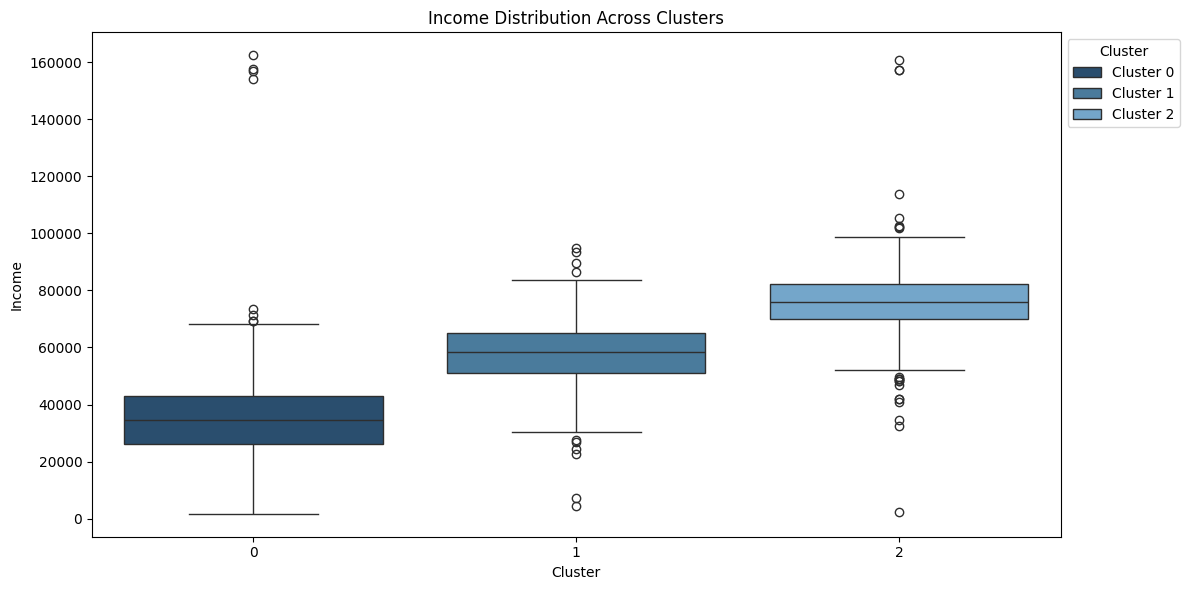

In [575]:
# Temporarily removing an outlier that makes the visual unclear
df_limit = df[df['Income'] < 600000]

colors = ['#1F4E79', '#3C7EAA', '#66A9D8']

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_limit, x='Cluster', y='Income', hue='Cluster', palette=colors)

# Adjusting the legend to show 'Cluster 0', 'Cluster 1', etc. instead of 0, 1, 2.
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [f'Cluster {int(label)}' for label in labels]

plt.legend(handles, new_labels, title="Cluster", loc='upper left', bbox_to_anchor=(1, 1))

plt.title("Income Distribution Across Clusters")
plt.tight_layout()
plt.show()


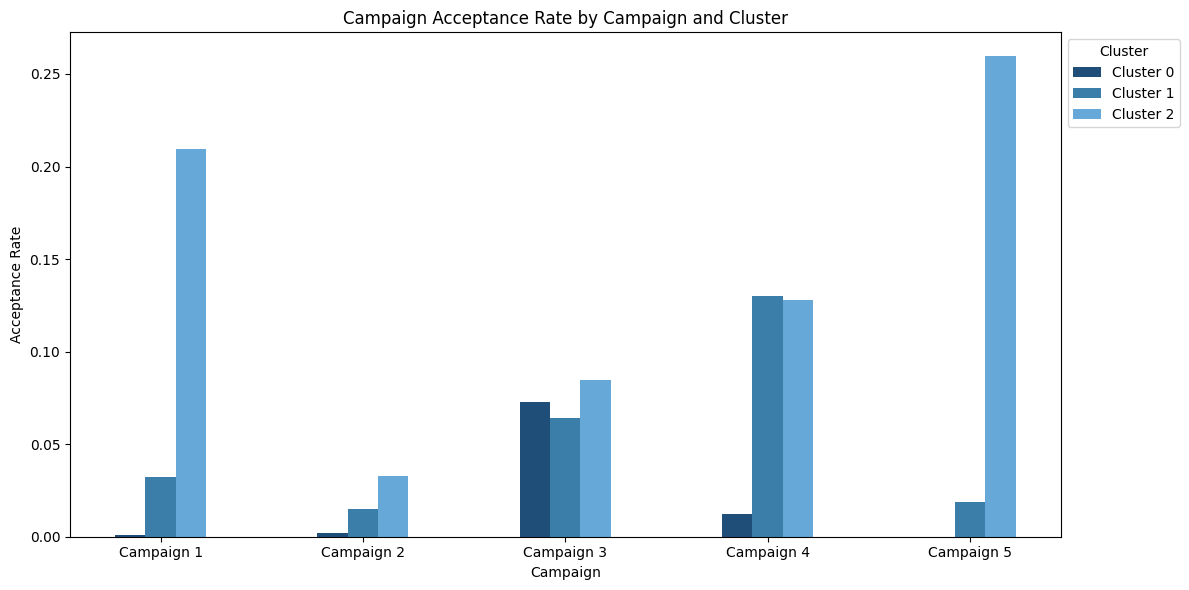

In [576]:
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
campaign_data = df.groupby('Cluster')[campaign_cols].mean()

# Rename columns by replacing the "AcceptedCmp" prefix
campaign_data = campaign_data.rename(columns=lambda x: x.replace('AcceptedCmp', 'Campaign '))
colors = ['#1F4E79', '#3C7EAA', '#66A9D8', '#8FB7D9', '#A6D1E5']


plt.figure(figsize=(12, 6))

# Set the width of the bars
bar_width = 0.15
# Set the positions of the bars on the x-axis
x_positions = range(len(campaign_cols))

# Plot each cluster as a separate bar for each campaign
for idx, cluster in enumerate(campaign_data.index):
    # Plot each campaign for the current cluster
    plt.bar([pos + bar_width * idx for pos in x_positions], 
            campaign_data.loc[cluster], 
            width=bar_width, 
            label=f'Cluster {cluster}', 
            color=colors[idx % len(colors)])

# Customize the plot
plt.title("Campaign Acceptance Rate by Campaign and Cluster")
plt.xlabel("Campaign")
plt.ylabel("Acceptance Rate")
plt.xticks([pos + bar_width * (len(campaign_data.index) / 2 - 0.5) for pos in x_positions], 
           campaign_data.columns, rotation=0)  # Center the campaign labels
plt.legend(title="Cluster", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [577]:
"""# Drop columns with few unique values for scatterplot visual
x = df.drop(columns=df.columns[(df.nunique() < 4) & (df.columns != 'Cluster')])

sns.pairplot(x, hue='Cluster', palette='Set2', diag_kind='kde')

plt.show()"""

"# Drop columns with few unique values for scatterplot visual\nx = df.drop(columns=df.columns[(df.nunique() < 4) & (df.columns != 'Cluster')])\n\nsns.pairplot(x, hue='Cluster', palette='Set2', diag_kind='kde')\n\nplt.show()"

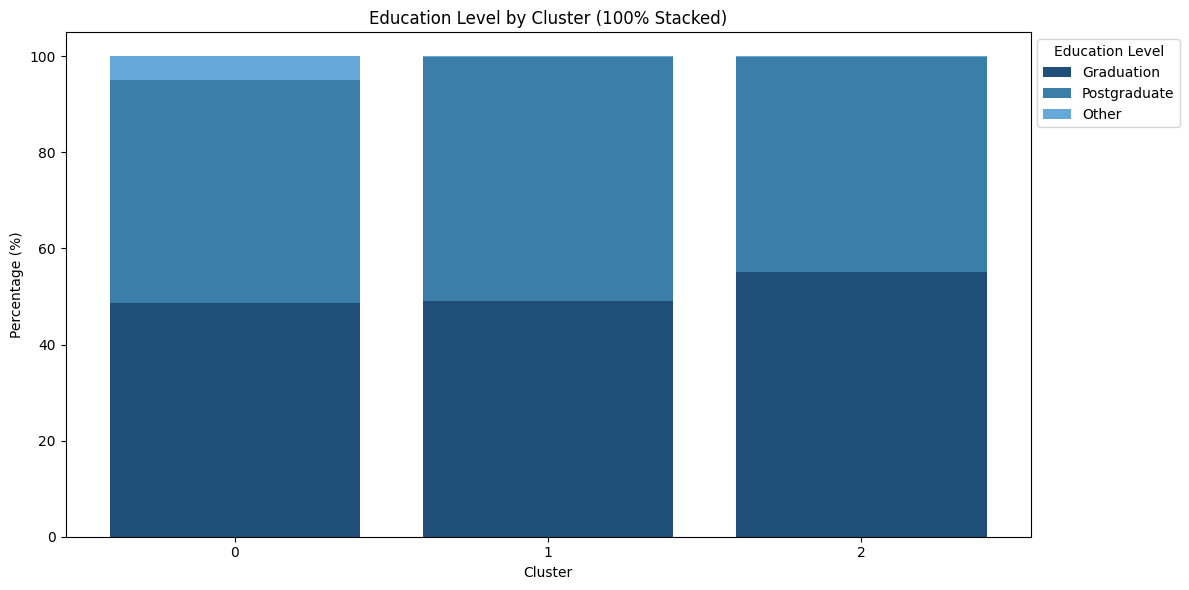

In [578]:
education_columns = ['Education_Graduation', 'Education_Postgraduate', 'Education_Other']

# Calculate mean percentages by cluster and normalize
education_data = df.groupby('Cluster')[education_columns].mean()
education_data = education_data.div(education_data.sum(axis=1), axis=0) * 100

# Rename columns by removing the "Education_" prefix
education_data = education_data.rename(columns=lambda x: x.replace('Education_', ''))

# Plotting 100% stacked bar chart
plt.figure(figsize=(12, 6))

# Custom color palette
colors = ['#1F4E79', '#3C7EAA', '#66A9D8']

# Plot each education level as a stacked bar segment
bottoms = [0] * len(education_data.index)
for idx, col in enumerate(education_data.columns):
    plt.bar(education_data.index, education_data[col], bottom=bottoms, label=col, color=colors[idx])
    bottoms += education_data[col]

# Customize the plot
plt.title("Education Level by Cluster (100% Stacked)")
plt.xlabel("Cluster")
plt.ylabel("Percentage (%)")
plt.xticks(ticks=education_data.index, labels=education_data.index, rotation=0)
plt.legend(title="Education Level", loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()
plt.show()

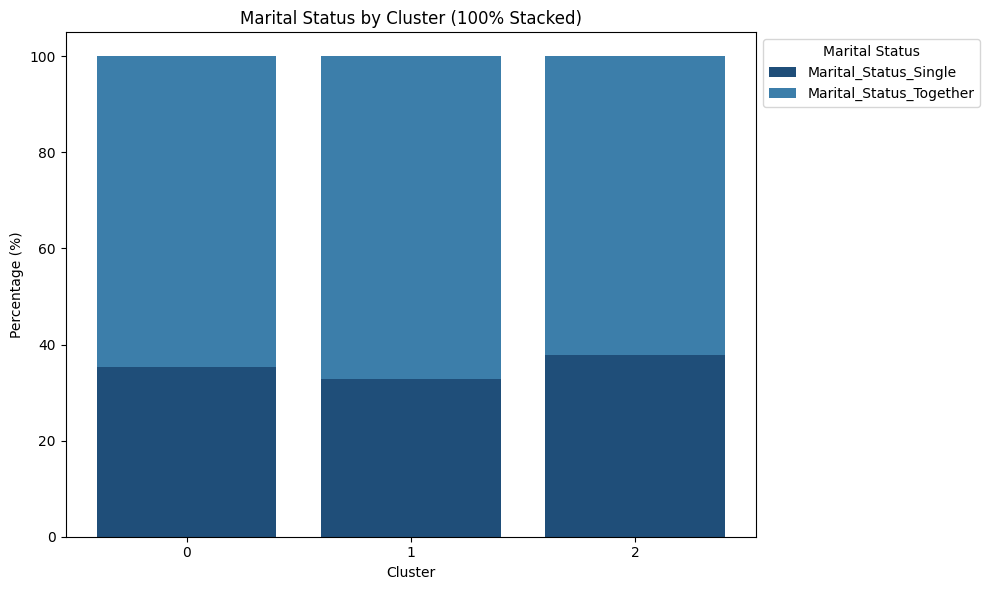

In [579]:
Marital_columns = ['Marital_Status_Single', 'Marital_Status_Together']

# Calculate mean percentages by cluster and normalize to make the sums 100% per cluster
Marital_data = df.groupby('Cluster')[Marital_columns].mean()
Marital_data = Marital_data.div(Marital_data.sum(axis=1), axis=0) * 100

colors = ['#1F4E79', '#3C7EAA']

plt.figure(figsize=(10, 6))

# Plot each marital status as a stacked bar segment
bottoms = [0] * len(Marital_data.index)
for idx, col in enumerate(Marital_columns):
    plt.bar(Marital_data.index, Marital_data[col], bottom=bottoms, label=col, color=colors[idx])

    # Update the bottoms for the next stacked segment
    bottoms += Marital_data[col]

plt.title("Marital Status by Cluster (100% Stacked)")
plt.xlabel("Cluster")
plt.ylabel("Percentage (%)")
plt.legend(title="Marital Status", loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(ticks=Marital_data.index, labels=Marital_data.index, rotation=0)

plt.tight_layout()
plt.show()


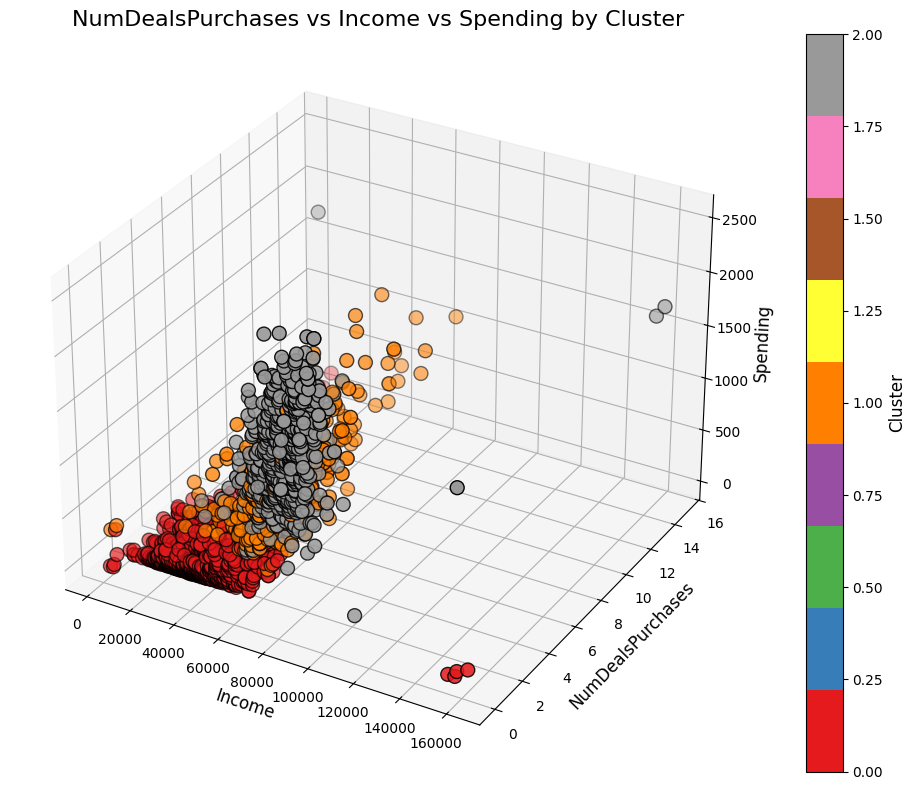

In [580]:
from mpl_toolkits.mplot3d import Axes3D

# Set the variables for the axes
x = 'Income'  # Variable representing income
y = 'NumDealsPurchases'  # Variable representing number of deals purchased
z = 'Spending'  # Variable representing spending

# Filter the data if needed, for example, removing outliers
df_limit = df[df['Income'] < 600000]

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot, using 'Cluster' for color coding
scatter = ax.scatter(df_limit[x], df_limit[y], df_limit[z], c=df_limit['Cluster'], cmap='Set1', s=100, edgecolor='black')

# Add plot titles and labels
ax.set_title(f"{y} vs {x} vs {z} by Cluster", fontsize=16)
ax.set_xlabel(x, fontsize=12)
ax.set_ylabel(y, fontsize=12)
ax.set_zlabel(z, fontsize=12)

# Create a color bar for the clusters
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()
